In [215]:
import sys
sys.path.append("../")
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data

import ThinLens.Elements
import ThinLens.Maps as Maps
from ThinLens.Models import F0D0Model, SIS18_Cell_minimal, SIS18_Cell, \
    SIS18_Lattice_minimal, SIS18_Lattice

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200
from IPython.display import set_matplotlib_formats, display
set_matplotlib_formats('pdf', "svg")
import matplotlib.pyplot as plt
import numpy as np

import cpymad.madx

from ThinLens.Beam import Beam
import tools.plot

In [216]:
slices = 4
quadSliceMultiplicity = 1

device = torch.device("cpu")
outputPerElement = True  # exceeds outputAtBPM
outputAtBPM = True

# set up models
Lattice = SIS18_Cell_minimal

k1f, k1d = -4.78047e-01, 3.12391e-01
        
model = Lattice(k1f=k1f, k1d=k1d, slices=slices, quadSliceMultiplicity=quadSliceMultiplicity,).to(device)
accelerator = Lattice(k1f=0.98*k1f, k1d=0.98*k1d, slices=slices, quadSliceMultiplicity=quadSliceMultiplicity,).to(device)

In [217]:
model.requires_grad_(False)
accelerator.requires_grad_(False)

gradStorage = list()
k1nDiffList = list()

l = list()
for i, element in enumerate(model.elements):
    if type(element) is ThinLens.Elements.Quadrupole:
        print("found quad")
        element.k1n.requires_grad_(True)
        
        gradStorage.append(list())
        l.append(accelerator.elements[i].k1n.item() - element.k1n.item())

k1nDiffList.append(l)

found quad
found quad
found quad


create training data

In [218]:
beam = Beam(mass=18.798, energy=19.0, exn=1.258e-6, eyn=2.005e-6, sigt=0.01, sige=0.000, particles=500)
bunch = beam.bunch.double().to(device)
label = accelerator(bunch, outputPerElement=outputPerElement, outputAtBPM=outputAtBPM).to(device)

trainSet = torch.utils.data.TensorDataset(bunch, label)
trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=25,
                                          shuffle=True, num_workers=2)

In [219]:
epochs = 50

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=5e7, momentum=0.7)
# optimizer = optim.Adam(model.parameters(), lr=1e+0)

# train loop
t0 = time.time()

for epoch in range(epochs):
    for i, data in enumerate(trainLoader, 0):
        bunch, label = data[0], data[1]

        optimizer.zero_grad()

        out = model(bunch, outputPerElement=outputPerElement, outputAtBPM=outputAtBPM)

        # loss = criterion(out, label)  # full phase-space
        loss = criterion(out[:, [0, 2], :], label[:, [0, 2], :])  # only x-, y-plane

        loss.backward()
        
        # save gradients
        i = 0
        for param in model.parameters():
            if param.requires_grad:
                gradStorage[i].append(param.grad.item())
                i += 1
        
        # modify weights
        optimizer.step()

    # if epoch % 10 == 9:
    #     print(loss.item())
    print(loss.item())
    
    # store k1n
    l = list()
    for i, element in enumerate(model.elements):
        if type(element) is ThinLens.Elements.Quadrupole:
            l.append(accelerator.elements[i].k1n.item() - element.k1n.item())
            
    k1nDiffList.append(l)

print("training completed within {:.2f}s".format(time.time() - t0))

3.15904710700586e-15
2.414681250655805e-15
2.6400055875361855e-15
2.1791632132728335e-15
9.551531127562048e-16
3.228218363868035e-15
1.175337404478216e-15
1.4830208650208015e-15
1.0639635147065278e-15
9.956060995160493e-16
6.796885729013891e-16
7.260128332470205e-16
9.236131110225253e-16
5.046741177806104e-16
3.111738679293587e-16
2.718365174721931e-16
1.824088874846241e-16
2.0472500363348735e-16
3.607801114764517e-16
1.6927413785721163e-16
4.486741868791904e-16
1.2952026750215703e-16
1.505381905170666e-16
2.180755594144886e-16
1.8352635871855168e-16
1.0024042624786952e-16
1.1500478732274416e-16
1.0885662611710942e-16
5.13466926190216e-17
1.1541139575053465e-16
6.6712787635813e-17
3.528017900441572e-17
3.371007971503171e-17
3.6817214360324724e-17
2.92644632362142e-17
2.1092573078632312e-17
2.803382868755551e-17
1.2073344843099028e-17
1.450933430871134e-17
1.532945505110564e-17
2.1299160350132612e-17
9.697490990023674e-18
8.900839093614349e-18
7.987247630667784e-18
1.587052720993849e-17

plot gradients

Text(0, 0.5, 'grad')

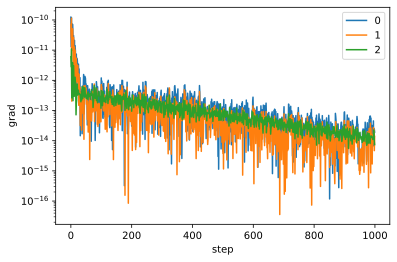

In [220]:
gradFig, gradAx = plt.subplots()

for i, param in enumerate(gradStorage):
    param = np.abs(param)
    gradAx.plot(param, label="{}".format(i))

gradAx.legend()
gradAx.set_yscale("log")
gradAx.set_xlabel("step")
gradAx.set_ylabel("grad")

plot k1n differences

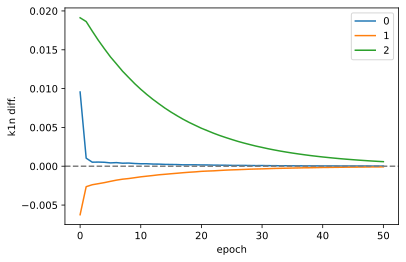

In [221]:
k1nDiff = np.array(k1nDiffList).transpose()

k1nFig, k1nAx = plt.subplots()

for i, k1n in enumerate(k1nDiff):
    k1nAx.plot(k1n, label="{}".format(i))

k1nAx.legend()
k1nAx.set_xlabel("epoch")
k1nAx.set_ylabel("k1n diff.")

k1nAx.axhline(0, linestyle="dashed", color="grey")